In [ ]:
import os
import glob
import shutil
import numpy as np
import casadi as ca
import matplotlib.pyplot as plt

In [17]:
# Parameters
wheel_radius = 0.016 # m
distance_between_wheels = 0.089 # m
max_vel_leftwheel = 157.08 # rad/s
min_vel_leftwheel = 15 # rad/s
max_vel_rightwheel = 77.08 # rad/s
min_vel_rightwheel = 15 # rad/s
time_step = 0.01 # s

In [18]:
class TO_MPC():
    def __init__(self, config_file_path=None):
        # Parameters
        self.N = 10
        self.dt = 0.1
        self.nx = 3
        self.nu = 2

        # State limits
        x_min = [-20.0, -20.0, -ca.inf]
        x_max = [20.0, 20.0, ca.inf]

        # Control limits
        u_min = [min_vel_leftwheel, min_vel_rightwheel]
        u_max = [max_vel_leftwheel, max_vel_rightwheel]
        
        # Cost function weights
        Q = ca.diag([10.0, 10.0, 0.1])
        QN = ca.diag([10.0, 10.0, 0.1])
        R = ca.diag([0.0, 0.0])

        # Initial and reference states
        x_init = ca.MX.sym("x_init", self.nx)
        x_ref = ca.MX.sym("x_ref", self.nx)

        # OCP formulation
        X = []
        self.lbX = []
        self.ubX = []
        G = []
        self.lbG = []
        self.ubG = []
        P = []
        J = 0

        for k in range(self.N):
            x = ca.MX.sym(f"x_{k}", self.nx)
            X.append(x)
            self.lbX.extend(x_min)
            self.ubX.extend(x_max)

            G.append(
                x - x_init
                if k == 0
                else x - self.robot_dynamics(x_prev, u_prev, self.dt)  # noqa: F821
            )
            self.lbG.extend(self.nx * [0])
            self.ubG.extend(self.nx * [0])

            u = ca.MX.sym(f"u_{k}", self.nu)
            X.append(u)
            self.lbX.extend(u_min)
            self.ubX.extend(u_max)

            J += (x - x_ref).T @ Q @ (x - x_ref) + u.T @ R @ u

            x_prev = x
            u_prev = u

        x = ca.MX.sym(f"x_{self.N}", self.nx)

        X.append(x)
        self.lbX.extend(x_min)
        self.ubX.extend(x_max)

        G.append(x - self.robot_dynamics(x_prev, u_prev, self.dt))
        self.lbG.extend(self.nx * [0])
        self.ubG.extend(self.nx * [0])

        J += (x - x_ref).T @ QN @ (x - x_ref)

        # NLP parameters
        P.extend([x_init, x_ref])

        # NLP formulation
        nlp = {"f": J, "x": ca.vertcat(*X), "g": ca.vertcat(*G), "p": ca.vertcat(*P)}
        casadi_tmp_dir = "casadi_tmp/"
        os.makedirs(casadi_tmp_dir, exist_ok=True)
        opts = {
            "ipopt": {
                "print_level": 4,
                "max_wall_time": self.dt,
                "warm_start_init_point": "yes",
                "hsllib": "/usr/local/lib/libcoinhsl.so",
                "linear_solver": "ma57", # "ma57" or "mumps"
            },
            "jit": True,
            "jit_options": {
                "flags": ["-O3", "-ffast-math"],
                "verbose": True,
                "compiler": "gcc",
                "directory": casadi_tmp_dir,
            }
        }

        print("Compiling NLP solver...")
        self.solver = ca.nlpsol("solver", "ipopt", nlp, opts)
        print("NLP solver compiled successfully.")

        [os.remove(filename) for filename in glob.glob("*.c")]
        shutil.rmtree(casadi_tmp_dir, ignore_errors=True)

        # Initialize variables
        self.initiaize_variables()

    def robot_dynamics(self, x, u, dt):
        v_left, v_right = u[0], u[1]
        v = wheel_radius * (v_left + v_right) / 2.0
        omega = wheel_radius * (v_right - v_left) / distance_between_wheels

        x_next = ca.vertcat(
            x[0] + v * ca.cos(x[2]) * dt,
            x[1] + v * ca.sin(x[2]) * dt,
            x[2] + omega * dt
        )
        return x_next
    
    def initiaize_variables(self):
        self.x_opt = np.zeros(len(self.lbX))
        self.lam_x_opt = np.zeros(len(self.lbX))
        self.lam_g_opt = np.zeros(len(self.lbG))

    def solve(self, x_init, x_ref):
        P = []
        P.append(x_init)
        P.append(x_ref)
        P = ca.vertcat(*P)

        opt_sol = self.solver(
            x0=self.x_opt,
            lam_x0=self.lam_x_opt,
            lam_g0=self.lam_g_opt,
            lbx=self.lbX,
            ubx=self.ubX,
            lbg=self.lbG,
            ubg=self.ubG,
            p=P,
        )

        self.x_opt = opt_sol["x"].full().flatten()
        self.lam_x_opt = opt_sol["lam_x"]
        self.lam_g_opt = opt_sol["lam_g"]

        u_opt = self.x_opt[self.nx + 0:self.nx + 2]
        return u_opt

In [19]:
to_mpc = TO_MPC()

Compiling NLP solver...
CasADi - 2025-07-03 10:25:09 MESSAGE("calling "gcc -O3 -ffast-math -fPIC -c jit_tmpke8d0u.c -o ./casadi_tmp/tmp_casadi_compiler_shellg1RnJe.o"") [.../casadi/solvers/shell_compiler.cpp:229]
CasADi - 2025-07-03 10:25:10 MESSAGE("calling "gcc ./casadi_tmp/tmp_casadi_compiler_shellg1RnJe.o -o ./casadi_tmp/tmp_casadi_compiler_shellg1RnJe.so -shared"") [.../casadi/solvers/shell_compiler.cpp:248]
NLP solver compiled successfully.


CasADi - 2025-07-03 10:25:10 WARNING("Failed to remove casadi_tmp/jit_tmppEnB1X.c") [.../casadi/core/function_internal.cpp:133]
CasADi - 2025-07-03 10:25:10 WARNING("Failed to remove ./casadi_tmp/tmp_casadi_compiler_shellpXzebo.so") [.../casadi/solvers/shell_compiler.cpp:66]
CasADi - 2025-07-03 10:25:10 WARNING("Failed to remove ./casadi_tmp/tmp_casadi_compiler_shellpXzebo.o") [.../casadi/solvers/shell_compiler.cpp:67]


In [20]:
def simulator(x, u, dt=0.01):
    v_left, v_right = u[0], u[1]
    v = wheel_radius * (v_left + v_right) / 2.0
    omega = wheel_radius * (v_right - v_left) / distance_between_wheels

    x_next = np.array(
        [
            x[0] + v * np.cos(x[2]) * dt,
            x[1] + v * np.sin(x[2]) * dt,
            x[2] + omega * dt
        ]
    )
    return x_next

def goal_reached(x, goal, min_dist):
    dist = np.linalg.norm(np.array(x[:2]) - np.array(goal[:2])) + np.abs(x[2] - goal[2])
    return dist < min_dist

In [28]:
start = [0.0, 0.0, 0.0]
goal = [0.0, -5.0, -np.pi/2]
min_dist_to_goal = 0.5

T = 15.0  # Simulation time in seconds
N = int(T / time_step)  # Number of time steps
time_to_goal = np.inf  # Initialize time to goal

x_traj = np.zeros((N + 1, 3))
u_traj = np.zeros((N, 2))

x_traj[0] = start
to_mpc.initiaize_variables()

for i in range(N):
    if goal_reached(x_traj[i], goal, min_dist_to_goal):
        time_to_goal = i * time_step
        print(40 * "-")
        print(f"Goal reached at time {time_to_goal:.2f} seconds.")
        print(40 * "-")
        x_traj[i + 1:] = x_traj[i]
        break

    u_opt = to_mpc.solve(x_traj[i], goal)
    u_traj[i] = u_opt
    x_traj[i + 1] = simulator(x_traj[i], u_opt, dt=time_step)

Total number of variables............................:       53
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       42
                     variables with only upper bounds:        0
Total number of equality constraints.................:       33
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0


Number of Iterations....: 22

                                   (scaled)                 (unscaled)
Objective...............:   2.2262331417475439e+03    2.2262331417475439e+03
Dual infeasibility......:   6.0229599085914742e-13    6.0229599085914742e-13
Constraint violation....:   7.9034001565503331e-15    7.9034001565503331e-15
Variable bound violation:   1.5185503343673190e-06    1.5185503343673190e-06
Complementari

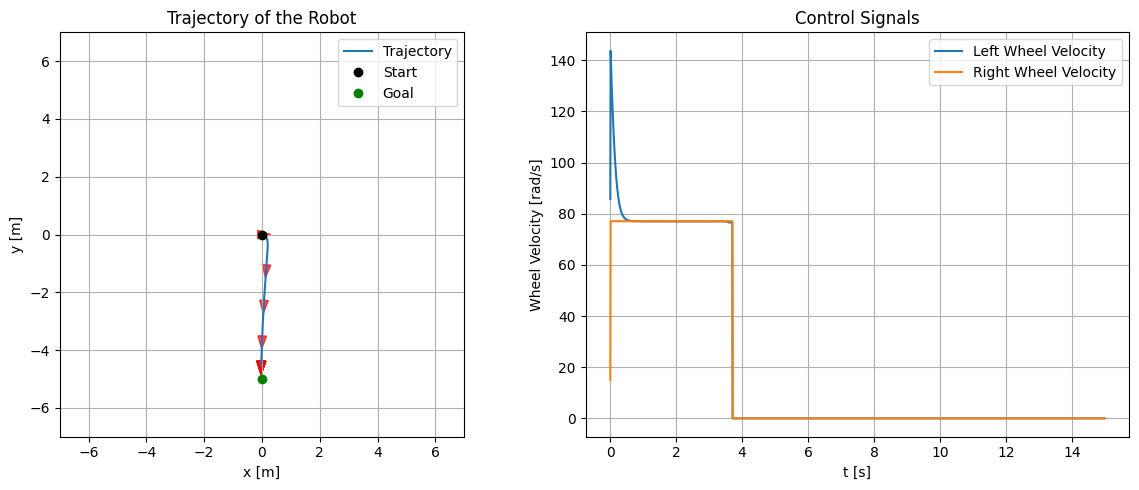

In [29]:
def plot_robot(ax, x, y, theta, color='r', size=0.3, alpha=0.7):
    triangle = np.array([
        [size, 0],
        [-size/2, size/2],
        [-size/2, -size/2]
    ])
    R = np.array([
        [np.cos(theta), -np.sin(theta)],
        [np.sin(theta),  np.cos(theta)]
    ])
    tri_world = (R @ triangle.T).T + np.array([x, y])
    ax.fill(tri_world[:, 0], tri_world[:, 1], color=color, alpha=alpha)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Trajectory plot
ax1.plot(x_traj[:, 0], x_traj[:, 1], label='Trajectory')
ax1.plot(start[0], start[1], 'ko', label='Start')
ax1.plot(goal[0], goal[1], 'go', label='Goal')
for t in range(0, int(T)+1):
    idx = min(int(t / time_step), x_traj.shape[0]-1)
    plot_robot(ax1, x_traj[idx, 0], x_traj[idx, 1], x_traj[idx, 2], color='r')
ax1.set_xlabel('x [m]')
ax1.set_ylabel('y [m]')
ax1.set_title('Trajectory of the Robot')
ax1.set_aspect("equal")
ax1.set_xlim([-7, 7])
ax1.set_ylim([-7, 7])
ax1.legend()
ax1.grid()

# Control plot
time_array = np.arange(N) * time_step
ax2.plot(time_array, u_traj[:, 0], label='Left Wheel Velocity')
ax2.plot(time_array, u_traj[:, 1], label='Right Wheel Velocity')
ax2.set_xlabel('t [s]')
ax2.set_ylabel('Wheel Velocity [rad/s]')
ax2.legend()
ax2.grid()
ax2.set_title('Control Signals')

plt.tight_layout()
plt.show()
